Recall the velocity equation
\begin{equation}
    V_R = -\frac{3}{\Sigma R^{1/2}} \frac{\partial}{\partial R}(\nu \Sigma R^{1/2}).
\end{equation}
Using the dimensionless variables $R = rR_0$, $\Sigma = \sigma \Sigma_0$, $\nu = \nu_0$ and $V_R = v_r v_0$ where $v_0 = \nu_0 / R_0$, we get
\begin{equation}
    v_r \left(\frac{\nu_0}{R_0}\right) = -\frac{3}{(\sigma \Sigma_0) (r^{1/2} R_0^{1/2})} \frac{1}{R_0} \frac{\partial}{\partial r} (\nu_0 \sigma \Sigma_0 r^{1/2} R_0^{1/2})
\end{equation}
which simplifies to
\begin{equation}
    v_r = -\frac{3}{\sigma r^{1/2}} \frac{\partial}{\partial r} (\sigma r^{1/2}).
\end{equation}
We use the substitution $X = r^{1/2}$ and recall that $g = 3 \sigma X$,
\begin{align}
    v_r
    &= -\frac{3}{\sigma X} \left[ \frac{1}{2X} \frac{\partial}{\partial X} (\sigma X) \right] \\
    &= -\frac{3}{2 \sigma X^2} \frac{\partial}{\partial X} (\sigma X) \\
    &= -\frac{3}{2 \sigma X^2} \left( \frac{1}{3} \frac{\partial g}{\partial X} \right) \\
    &= -\frac{1}{2 \sigma X^2} \frac{\partial g}{\partial X}.
\end{align}
We discretise the spatial derivative using a central difference approximation
\begin{equation}
    \frac{\partial g}{\partial X} \approx \frac{g_{i+1} - g_{i-1}}{2\Delta X}.
\end{equation}
Substituting this back gives the discrete equation for radial velocity at grid point $i$,
\begin{equation}
    (v_r)_i = -\frac{1}{2 \sigma_i X_i^2} \left( \frac{g_{i+1} - g_{i-1}}{2\Delta X} \right) = -\frac{g_{i+1} - g_{i-1}}{4 \sigma_i X_i^2 \Delta X}.
\end{equation}

Reached time tau = 0.002
Reached time tau = 0.008
Reached time tau = 0.032
Reached time tau = 0.128
Reached time tau = 0.512


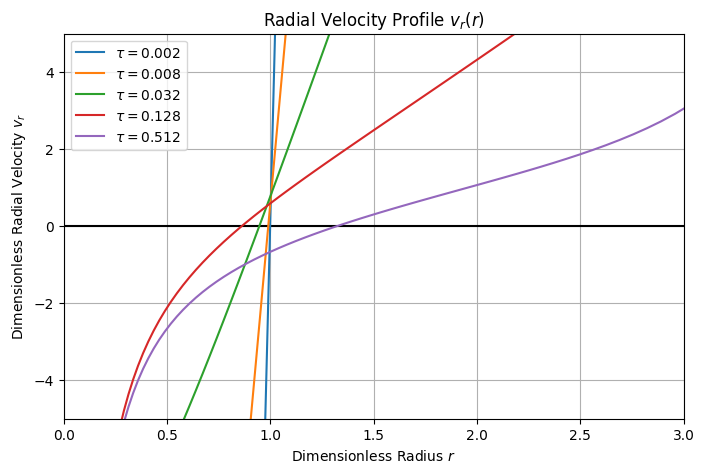

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def solve_and_plot_velocity():
    eta = 1.0
    N = 100
    X_min = 0.02
    X_max = 2.0

    X = np.linspace(X_min, X_max, N)
    dX = X[1] - X[0]
    r = X**2

    # Stability condition
    dt_limit = (2.0/3.0) * (dX**2) * (X_min**2)
    dt = 0.9 * dt_limit

    target_times = [0.002, 0.008, 0.032, 0.128, 0.512]

    # Initial conditions
    sigma = np.exp(-((X - 1)**2) / 0.001)
    sigma[0] = 0.0
    sigma[-1] = 0.0

    # Variables f and g
    f = 4 * (X**3) * sigma

    current_time = 0.0
    results = [] # To store (time, velocity_array, radius_array)

    for target in target_times:
        while current_time < target:
            # Time step control
            if current_time + dt > target:
                step_dt = target - current_time
            else:
                step_dt = dt

            # Update g
            g = 3 * eta * X * sigma

            # Diffusion step
            g_diff = g[2:] - 2*g[1:-1] + g[:-2]
            f[1:-1] += (step_dt / (dX**2)) * g_diff

            # Recover sigma
            sigma[1:-1] = f[1:-1] / (4 * (X[1:-1]**3))
            sigma[0] = 0.0
            sigma[-1] = 0.0

            current_time += step_dt

        # Calculate radial velocity at this target time
        # Formula: v_r = - (dg/dX) / (2 * sigma * X^2)
        g = 3 * eta * X * sigma
        dg_dX = np.gradient(g, dX)

        # Calculate velocity
        with np.errstate(divide='ignore', invalid='ignore'):
            vr = - dg_dX / (2 * sigma * (X**2))

        results.append((target, vr, r))
        print(f"Reached time tau = {target}")

    plt.figure(figsize=(8, 5))
    plt.axhline(0, color='black', linestyle='-')
    for t, vel, rad in results:
        plt.plot(rad[5:-5], vel[5:-5], label=f'$\\tau = {t}$')
    plt.title(r'Radial Velocity Profile $v_r(r)$')
    plt.xlabel(r'Dimensionless Radius $r$')
    plt.ylabel(r'Dimensionless Radial Velocity $v_r$')
    plt.ylim(-5, 5)
    plt.xlim(0, 3)
    plt.legend()
    plt.grid(True)
    plt.show()

solve_and_plot_velocity()

For small radii $r < 1$, the velocity is negative. This represents the accretion flow where matter drifts inwards towards the central object. For large radii $r > 1$, the velocity becomes positive. This represents the viscous spreading of the disc, where angular momentum is transported outwards, pushing material to larger radii. As time increases, the transition point between inflow and outflow initially moves to smaller radii, then after the peak touches the boundary, the transition point moves to larger radii.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import sys

def print_progress(current_time, total_time):
    percent = min(100.0, 100.0 * (current_time / total_time))
    bar_length = 30
    filled = int(bar_length * percent / 100)
    bar = '█' * filled + '-' * (bar_length - filled)
    sys.stdout.write(f'\rProgress: |{bar}| {percent:.1f}% ')
    sys.stdout.flush()

def fast_interp_velocity(r_particles, X_min, inv_dX, v_grid_full):
    '''
    Interpolation X = sqrt(r) -> index = (X - X_min) / dX
    '''
    # Map r to X space
    X_p = np.sqrt(r_particles)

    # Calculate continuous index
    idx_float = (X_p - X_min) * inv_dX

    # Get integer part and clamp to valid grid range
    N = len(v_grid_full)
    idx = idx_float.astype(np.int32)
    np.clip(idx, 0, N - 2, out=idx)

    # Calculate weight (alpha) for linear interpolation
    alpha = idx_float - idx
    np.clip(alpha, 0.0, 1.0, out=alpha)

    # Interpolate: v = v[i]*(1-a) + v[i+1]*a
    v_out = v_grid_full[idx] * (1.0 - alpha) + v_grid_full[idx+1] * alpha
    return v_out

def run_fast_simulation():
    # Parameters and pre-computation
    eta = 1.0
    N = 100
    X_min = 0.02
    X_max = 2.0

    X = np.linspace(X_min, X_max, N)
    dX = X[1] - X[0]
    inv_dX = 1.0 / dX         # Pre-compute division
    inv_2dX = 0.5 * inv_dX    # For gradient: 1/(2*dX)
    inv_dX2 = inv_dX * inv_dX # For diffusion: 1/dX^2

    r_grid = X**2
    r_inner_bound = r_grid[1]
    r_outer_bound = r_grid[-2]

    # Stability dt
    dt = 0.9 * (2.0/3.0) * (dX**2) * (X_min**2)
    t_final = 1.0

    # Pre-compute diffusion coefficient
    diff_coeff = dt * inv_dX2

    # Initial conditions
    sigma = np.exp(-((X - 1)**2) / 0.001)
    sigma[0] = 0.0
    sigma[-1] = 0.0

    # f and g arrays
    f = 4 * (X**3) * sigma

    # Pre-compute factors for sigma
    # sigma = f / (4 * X^3)
    inv_4X3 = 1.0 / (4 * (X**3))
    # Handle potentially zero division at boundary by keeping 0
    inv_4X3[0] = 0.0

    # Pre-compute factors for velocity
    inv_2r = 0.5 / r_grid

    # Trace Particles
    trace_r0 = np.array([0.9, 0.95, 1.0, 1.05, 1.1])
    trace_pos = trace_r0.copy()
    trace_active = np.ones(len(trace_r0), dtype=bool)
    trace_hist = {r0: {'t': [], 'r': []} for r0 in trace_r0}

    # Stats Particles
    stats_r0 = np.linspace(0.9, 1.1, 51)
    stats_pos = stats_r0.copy()
    stats_active = np.ones(len(stats_r0), dtype=bool)
    stats_max_r = stats_r0.copy()
    stats_t_max = np.zeros_like(stats_r0)
    stats_t_exit = np.full_like(stats_r0, np.nan)
    stats_exit_type = np.zeros_like(stats_r0, dtype=int)

    # Arrays for manual gradient calculation
    vr_full = np.zeros(N)

    current_time = 0.0
    step = 0

    # Main loop
    while current_time < t_final:

        # Fluid update
        # Compute g
        g = 3 * eta * X * sigma

        # Diffusion step
        g_interior = g[1:-1]
        g_diff = g[2:] - 2*g_interior + g[:-2]

        # Update f
        f[1:-1] += diff_coeff * g_diff

        # Recover sigma
        sigma = f * inv_4X3
        # Enforce boundary conditions
        sigma[0] = 0.0
        sigma[-1] = 0.0

        # Velocity field
        dg_dx_interior = (g[2:] - g[:-2]) * inv_2dX
        denom = sigma[1:-1] * (2 * r_grid[1:-1]) + 1e-30
        vr_interior = -dg_dx_interior / denom

        # Fill full velocity array
        vr_full[1:-1] = vr_interior
        vr_full[0] = vr_interior[0]   # Clamp boundary
        vr_full[-1] = vr_interior[-1] # Clamp boundary

        # Particle update

        # Trace Particles
        if trace_active.any():
            idx = np.where(trace_active)[0]
            r_curr = trace_pos[idx]

            # Interpolation
            v_p = fast_interp_velocity(r_curr, X_min, inv_dX, vr_full)
            r_new = r_curr + v_p * dt

            # Boundary checks
            hit_inner = r_new <= r_inner_bound
            r_new[hit_inner] = 0.0

            hit_outer = r_new >= r_outer_bound
            r_new[hit_outer] = r_outer_bound

            trace_pos[idx] = r_new
            trace_active[idx] = ~(hit_inner | hit_outer)

        # Record history periodically
        if step % 500 == 0:
            for i, r0 in enumerate(trace_r0):
                trace_hist[r0]['t'].append(current_time)
                trace_hist[r0]['r'].append(trace_pos[i])

        # Stats particles
        if stats_active.any():
            idx = np.where(stats_active)[0]
            r_curr = stats_pos[idx]

            v_p = fast_interp_velocity(r_curr, X_min, inv_dX, vr_full)
            r_new = r_curr + v_p * dt

            # Max radius
            is_larger = r_new > stats_max_r[idx]
            stats_max_r[idx[is_larger]] = r_new[is_larger]
            stats_t_max[idx[is_larger]] = current_time

            # Boundary checks
            hit_in = r_new <= r_inner_bound
            hit_out = r_new >= r_outer_bound

            if hit_in.any():
                g_idx = idx[hit_in]
                stats_t_exit[g_idx] = current_time
                stats_exit_type[g_idx] = 1
                stats_active[g_idx] = False
                r_new[hit_in] = 0.0

            if hit_out.any():
                g_idx = idx[hit_out]
                stats_exit_type[g_idx] = 2
                stats_active[g_idx] = False
                r_new[hit_out] = r_outer_bound

            stats_pos[idx] = r_new

        current_time += dt
        step += 1

        if step % 5000 == 0:
            print_progress(current_time, t_final)

    print_progress(1.0, 1.0)
    return trace_hist, stats_r0, stats_max_r, stats_t_max, stats_t_exit, stats_exit_type

res = run_fast_simulation()
history, r0_arr, max_r, t_max, t_exit, ex_type = res

Running optimized simulation (N=100, dt=9.60e-08)...
Progress: |██████████████████████████████| 100.0% 
Done.


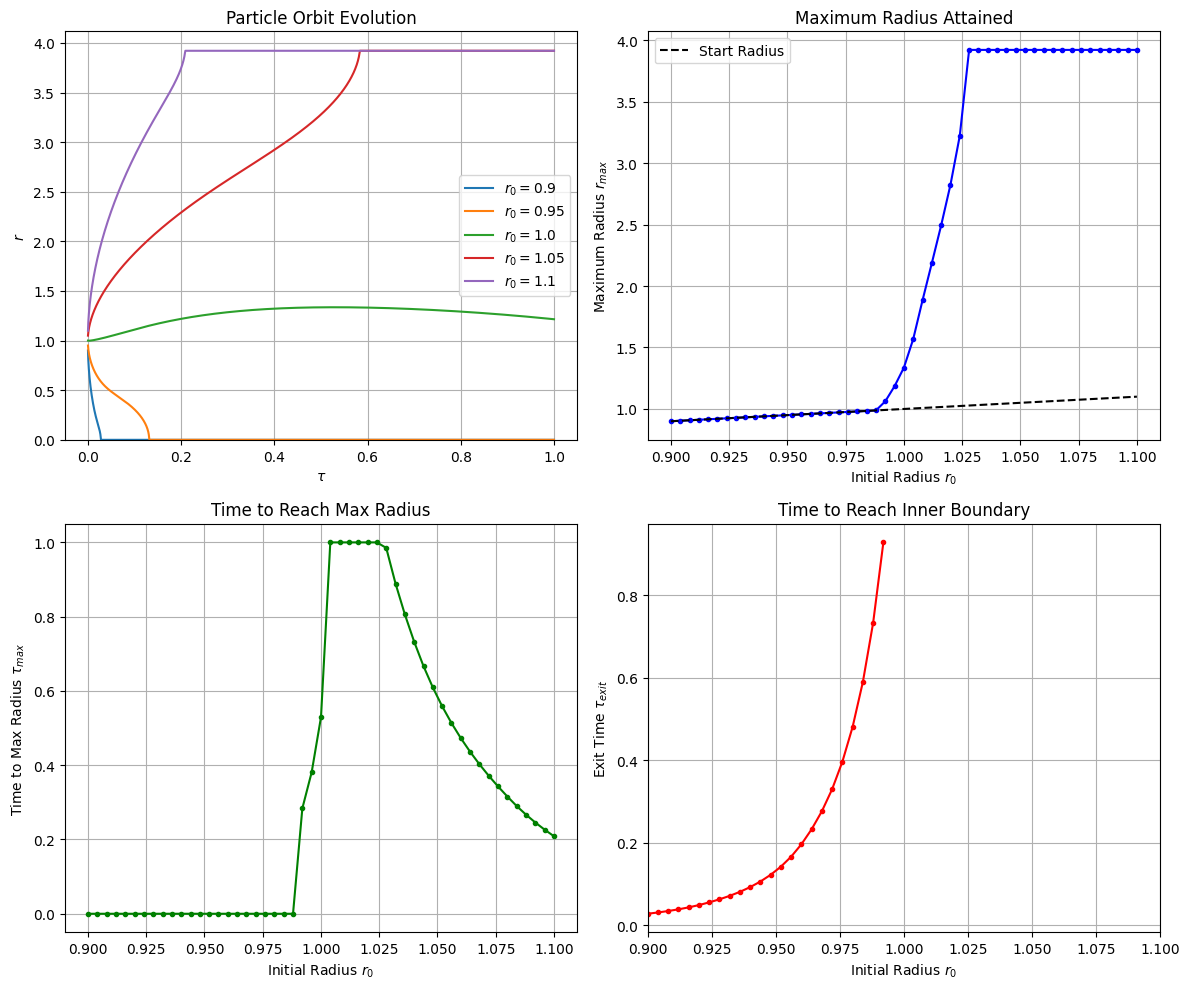

In [41]:
fig = plt.figure(figsize=(12, 10))

ax1 = plt.subplot(2, 2, 1)
for r0, data in history.items():
    ax1.plot(data['t'], data['r'], label=f'$r_0={r0}$')
ax1.set_title('Particle Orbit Evolution')
ax1.set_xlabel(r'$\tau$')
ax1.set_ylabel(r'$r$')
ax1.set_ylim(bottom=0)
ax1.legend()
ax1.grid(True)

ax2 = plt.subplot(2, 2, 2)
ax2.plot(r0_arr, max_r, 'b.-')
ax2.plot(r0_arr, r0_arr, 'k--', label='Start Radius')
ax2.set_xlabel(r'Initial Radius $r_0$')
ax2.set_ylabel(r'Maximum Radius $r_{max}$')
ax2.set_title('Maximum Radius Attained')
ax2.legend()
ax2.grid(True)

ax3 = plt.subplot(2, 2, 3)
ax3.plot(r0_arr, t_max, 'g.-')
ax3.set_xlabel(r'Initial Radius $r_0$')
ax3.set_ylabel(r'Time to Max Radius $\tau_{max}$')
ax3.set_title('Time to Reach Max Radius')
ax3.grid(True)

ax4 = plt.subplot(2, 2, 4)
in_mask = (ex_type == 1)
ax4.plot(r0_arr[in_mask], t_exit[in_mask], 'r.-')
ax4.set_xlabel(r'Initial Radius $r_0$')
ax4.set_ylabel(r'Exit Time $\tau_{exit}$')
ax4.set_title('Time to Reach Inner Boundary')
ax4.set_xlim(0.9, 1.1)
ax4.grid(True)

plt.tight_layout()
plt.show()

1. Particle orbit evolution:

    *   For small radii $r_0 < 1$, accretion cases the lines to drop rapidly to $0$. This confirms that mass in the inner region loses angular momentum and spirals onto the central object.
    *   For large radii $r_0 > 1$, the lines shoot upwards. This represents the outer material absorbing angular momentum from the inner material and moving to larger radii (viscous spreading). They hit the outer grid boundary $r=4$.
    *   At the transistion $r_0 = 1.0$, the line starts at the peak of the initial density. Initially, it moves outward, gaining angular momentum, reaches a maximum radius, and then begins to slowly drift back inward as the accretion flow eventually catches up to it.

2. Maximum radius attained:
    *  For $r_0 \ll 1$, the particles fall in immediately, so their maximum radius is simply their starting radius.
    *   For $r_0$ near $1$, the maximum radius explodes upwards. This is the explosion of the accretion disc spreading.
    *   The flat plateau at the top is the artificial outer boundary of the grid $X_{max}^2 = 4$. Particles starting a high initial radius hit this wall within the simulation time.

3. Time to reach maximum radius:
*   Again, for $r_0 \ll 1$, the particles fall in immediately, so the time to reach the maximum radius is $0$.
*   For the range near $r_0 = 1$, the particles are moving outwards for the entire duration of the simulation and have not turned back or hit the wall yet. Thus, their maximum radius time is the final simulation time.
*   For $r_0 \gg 1.025$, the time declines. Particles starting further out are closer to the outer wall, so they hit it sooner.

4. Accretion time
*   Only particles starting within $r < 1$ have enough time to accrete within $\tau=1$.
*   The time shoots up asymptotically as we approach $r_0 = 1$, implying that particles starting near the center of the mass distribution would take a very long time to finally lose enough angular momentum to fall in.

In [45]:
def get_simulation_params():
    '''
    Returns dictionary of simulation parameters.
    '''
    return {
        'N': 200,             # Grid resolution
        'eta': 1.0,           # Viscosity parameter
        'X_min': 0.02,
        'X_max': 2.0,
        't_target': 0.512,
        'particle_density': 4001,
        'particle_range': (0.8, 1.2)
    }

def setup_grid(params):
    '''
    Initialises spatial grid and pre-computed physics constants.
    '''
    X = np.linspace(params['X_min'], params['X_max'], params['N'])
    dX = X[1] - X[0]
    r = X**2
    grid_ops = {
        'dX': dX,
        'inv_dX': 1.0 / dX,
        'inv_dX2': 1.0 / (dX**2),
        'inv_2dX': 0.5 / dX,
        'dt': 0.9 * (2.0/3.0) * (dX**2) * (params['X_min']**2)
    }
    return X, r, grid_ops

def get_initial_sigma(r):
    '''
    Calculates initial surface density profile.
    '''
    # Sigma = exp( - (r^0.5 - 1)^2 / 0.001 )
    return np.exp(-((np.sqrt(r) - 1)**2) / 0.001)

def initialise_particles(params):
    '''
    Creates dense array of test particles.
    '''
    r_start, r_end = params['particle_range']
    p_r0 = np.linspace(r_start, r_end, params['particle_density'])

    return {
        'r0': p_r0,              # Initial positions (static)
        'pos': p_r0.copy(),      # Current positions (dynamic)
        'active': np.ones(len(p_r0), dtype=bool),
        'status': np.zeros(len(p_r0), dtype=int) # 0=Active, 1=Accreted, 2=Ejected
    }

In [47]:
def step_fluid(f, X, eta, grid_ops):
    '''
    Evolves the fluid surface density by one timestep.
    Returns updated f and the derived sigma and g arrays.
    '''
    # Recover sigma
    sigma = f / (4 * X**3 + 1e-30)
    sigma[0] = 0.0
    sigma[-1] = 0.0

    # Calculate flux g
    g = 3 * eta * X * sigma

    # Diffusion step, update f
    g_diff = g[2:] - 2*g[1:-1] + g[:-2]
    f[1:-1] += (grid_ops['dt'] * grid_ops['inv_dX2']) * g_diff

    return f, sigma, g

def compute_velocity_field(g, sigma, r, grid_ops):
    '''
    Calculates radial velocity v_r on the grid.
    '''
    N = len(g)
    vr = np.zeros(N)

    # Gradient dg/dX
    dg_dx = (g[2:] - g[:-2]) * grid_ops['inv_2dX']
    denom = (2 * sigma[1:-1] * r[1:-1]) + 1e-30
    vr[1:-1] = -dg_dx / denom

    # Clamp boundaries
    vr[0] = vr[1]
    vr[-1] = vr[-2]

    return vr

def step_particles(particles, vr_grid, grid_ops, r_bounds, X_min):
    '''
    Advects particles using the calculated velocity field.
    '''
    if not np.any(particles['active']):
        return particles

    idx = np.where(particles['active'])[0]
    r_curr = particles['pos'][idx]

    # Linear interpolation
    # Map r -> X space -> Grid Index
    X_p = np.sqrt(r_curr)
    idx_float = (X_p - X_min) * grid_ops['inv_dX']

    idx_i = idx_float.astype(np.int32)
    np.clip(idx_i, 0, len(vr_grid)-2, out=idx_i)

    alpha = idx_float - idx_i
    np.clip(alpha, 0.0, 1.0, out=alpha)

    # v = v[i]*(1-a) + v[i+1]*a
    v_interp = vr_grid[idx_i] * (1.0 - alpha) + vr_grid[idx_i+1] * alpha

    # Update position
    r_new = r_curr + v_interp * grid_ops['dt']

    # Boundary checks
    hit_in = r_new <= r_bounds[0]
    hit_out = r_new >= r_bounds[1]

    if np.any(hit_in):
        sub_idx = idx[hit_in]
        particles['status'][sub_idx] = 1 # Accreted
        particles['active'][sub_idx] = False
        r_new[hit_in] = 0.0

    if np.any(hit_out):
        sub_idx = idx[hit_out]
        particles['status'][sub_idx] = 2 # Ejected
        particles['active'][sub_idx] = False
        r_new[hit_out] = r_bounds[1]

    particles['pos'][idx] = r_new
    return particles

In [50]:
def integrate_mass_on_grid(sigma, X, dX):
    '''
    Integrates mass M, Integral(2 * Sigma * X^3 dX).
    '''
    integrand = 2 * sigma * (X**3)
    return np.trapezoid(integrand, dx=dX)

def integrate_initial_mass_range(r_start, r_end, X_min, X_max):
    '''
    Integrates the analytic initial mass profile between two radii.
    '''
    # Create fine grid
    X_fine = np.linspace(X_min, X_max, 2000)
    r_fine = X_fine**2
    dX_fine = X_fine[1] - X_fine[0]

    # Get mask for range
    mask = (r_fine >= r_start) & (r_fine <= r_end)
    if not np.any(mask):
        return 0.0

    # Analytic sigma
    sigma_fine = get_initial_sigma(r_fine)

    # Integrate
    integrand = 2 * sigma_fine[mask] * (X_fine[mask]**3)
    return np.trapezoid(integrand, dx=dX_fine)

def analyse_results(particles, sigma_final, X, r, dX, M_init_total, params):
    '''
    Performs the final Lagrangian vs Eulerian comparison.
    '''
    # Identify critical radii from particles
    # Find max r0 that has status 1 (Accreted)
    accreted_indices = np.where(particles['status'] == 1)[0]
    if len(accreted_indices) > 0:
        r_crit_in = np.max(particles['r0'][accreted_indices])
    else:
        r_crit_in = 0.0

    # Find min r0 that has status 2 (Ejected)
    ejected_indices = np.where(particles['status'] == 2)[0]
    if len(ejected_indices) > 0:
        r_crit_out = np.min(particles['r0'][ejected_indices])
    else:
        r_crit_out = params['X_max']**2

    print(f"\nLagrangian Analysis")
    print(f"Particles with r0 <= {r_crit_in:.4f} were accreted.")

    # Integrate mass based on ranges
    M_acc = integrate_initial_mass_range(0, r_crit_in, params['X_min'], params['X_max'])
    M_ej = 0.0
    if len(ejected_indices) > 0:
        M_ej = integrate_initial_mass_range(r_crit_out, 100, params['X_min'], params['X_max'])

    # Calculate theoretical total for normalisation
    M_total_theory = integrate_initial_mass_range(0, 100, params['X_min'], params['X_max'])

    f_acc = M_acc / M_total_theory
    f_ej = M_ej / M_total_theory
    f_rem_lagrangian = 1.0 - f_acc - f_ej

    print(f"Fraction Accreted: {f_acc:.4f} ({f_acc*100:.2f}%)")
    print(f"Fraction Ejected:  {f_ej:.4f} ({f_ej*100:.2f}%)")
    print(f"Fraction Remaining (1 - Acc - Ej): {f_rem_lagrangian:.4f} ({f_rem_lagrangian*100:.2f}%)")

    # Eulerian analysis
    M_rem_eulerian = integrate_mass_on_grid(sigma_final, X, dX)
    f_rem_eulerian = M_rem_eulerian / M_init_total # Normalize by grid initial total

    print(f"\nEulerian Analysis")
    print(f"Fraction Remaining on Grid: {f_rem_eulerian:.4f} ({f_rem_eulerian*100:.2f}%)")

    # 4. Conclusion
    diff = abs(f_rem_lagrangian - f_rem_eulerian)
    print(f"\nDifference: {diff:.5f}")
    if diff < 0.02:
        print("Conclusion: Excellent agreement between particle evolution and fluid equations.")
    else:
        print("Conclusion: Discrepancy detected.")

In [51]:
def run_simulation():
    # Initialisation
    params = get_simulation_params()
    X, r, grid_ops = setup_grid(params)
    particles = initialise_particles(params)

    # Initial fluid state
    sigma = get_initial_sigma(r)
    sigma[0] = 0; sigma[-1] = 0
    f = 4 * (X**3) * sigma

    # Calculate initial total mass
    M_init_total = integrate_mass_on_grid(sigma, X, grid_ops['dX'])

    current_time = 0.0
    step = 0
    r_bounds = (r[1], r[-2])

    # Time loop
    while current_time < params['t_target']:
        # Fluid Physics
        f, sigma, g = step_fluid(f, X, params['eta'], grid_ops)
        # Velocity Physics
        vr = compute_velocity_field(g, sigma, r, grid_ops)
        # Particle Physics
        particles = step_particles(particles, vr, grid_ops, r_bounds, params['X_min'])

        current_time += grid_ops['dt']
        step += 1

        if step % 2000 == 0:
            print_progress(current_time, params['t_target'])

    analyse_results(particles, sigma, X, r, grid_ops['dX'], M_init_total, params)

run_simulation()

Progress: |█████████████████████████████-| 100.0% 
Lagrangian Analysis
Particles with r0 <= 0.9824 were accreted.
Fraction Accreted: 0.3142 (31.42%)
Fraction Ejected:  0.1238 (12.38%)
Fraction Remaining (1 - Acc - Ej): 0.5619 (56.19%)

Eulerian Analysis
Fraction Remaining on Grid: 0.5441 (54.41%)

Difference: 0.01785
Conclusion: Excellent agreement between particle evolution and fluid equations.


Any particle starting inside the critical radius $r_{\text{crit, in}}$ has enough time to lose its angular momentum and spiral into the star by the simiulation end $\tau=0.512$.

Using the integration of the initial Gaussian density profile up to $r_{\text{crit, in}}$, we compute the mass fraction. Since the density peaks at $r=1$ and falls off sharply, this fraction represents the left side of the Gaussian hill sliding inwards.

The range of initial radii, denoted $r_{\text{crit, out}}$ is a small range at the far edge. At $\tau=0.512$, the spreading wave has moved outwards significantly, but mass starting near the peak $r=1$ has not yet hit the wall $r=4$.

The Lagrangian remnant is given by $1 - (\text{Fraction Accreted} + \text{Fraction Ejected})$. The Eulerian remnant, however, is calculated by simply summing the mass currently sitting on the grid at $\tau=0.512$. These two numbers are quite close, which confirms the agreement between particle evolution and the fluid equations.